## **GODADDY MICROBUSINESS DENSITY FORECASTING**



**Import Libraries And Load Data**

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sn; sn.set_style("white")

from datetime import datetime, date
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [2]:
train = pd.read_csv('train.csv')
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [4]:
test = pd.read_csv('test.csv')
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


**Unique Values**

In [5]:
print("Unique values in train.csv for categorical variables")
print(f"Counties: {train['cfips'].nunique()}")
print(f"States: {train['state'].nunique()}")
print(f"Months: {train['first_day_of_month'].nunique()}")

print(f"\nNumber of months for forecasting in test.csv: {test['first_day_of_month'].nunique()}")
print(f"Months in test.csv: {test['first_day_of_month'].unique()}")

Unique values in train.csv for categorical variables
Counties: 3135
States: 51
Months: 39

Number of months for forecasting in test.csv: 8
Months in test.csv: ['2022-11-01' '2022-12-01' '2023-01-01' '2023-02-01' '2023-03-01'
 '2023-04-01' '2023-05-01' '2023-06-01']


**Distribution of microbusiness_density**

In [6]:
train[['microbusiness_density', 'active']].describe()


,microbusiness_density,active
count,122265.000000,1.222650e+05
mean,3.817671,6.442858e+03
std,4.991087,3.304001e+04
min,0.000000,0.000000e+00
25%,1.639344,1.450000e+02
50%,2.586543,4.880000e+02
75%,4.519231,2.124000e+03
max,284.340030,1.167744e+06


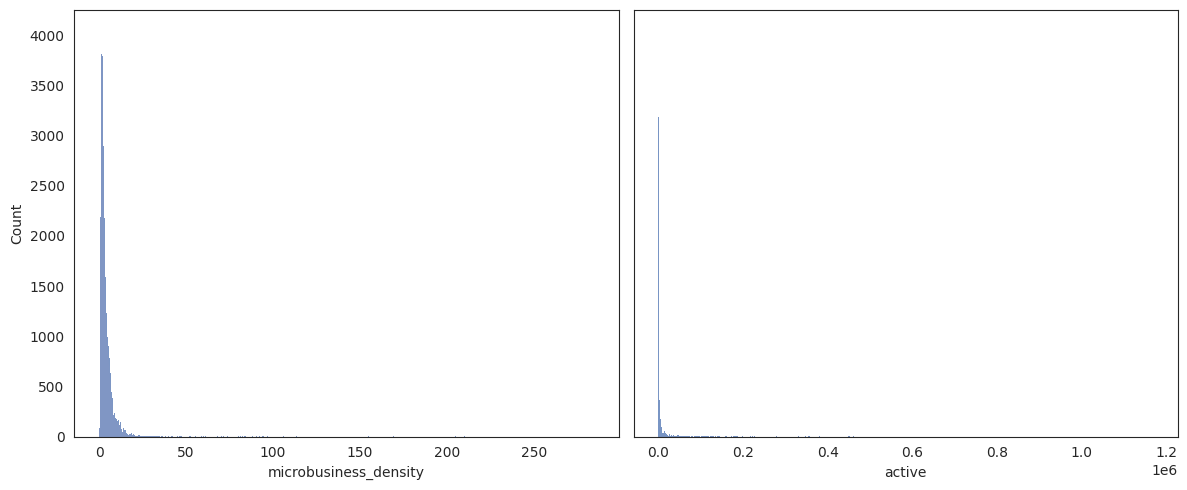

In [7]:
fig = plt.figure(figsize=(12,5))
x = 1
for feature in ['microbusiness_density', 'active']:
    ax = fig.add_subplot(1,2,x)
    sn.histplot(x=train[feature], color="#4C72B0")
    plt.ylim(0,4250)
    if x == 2:
        plt.tick_params(
            axis='y',
            which='both',
            left=False,
            labelleft=False)
        plt.ylabel("")
    x+=1
plt.tight_layout()
plt.show()

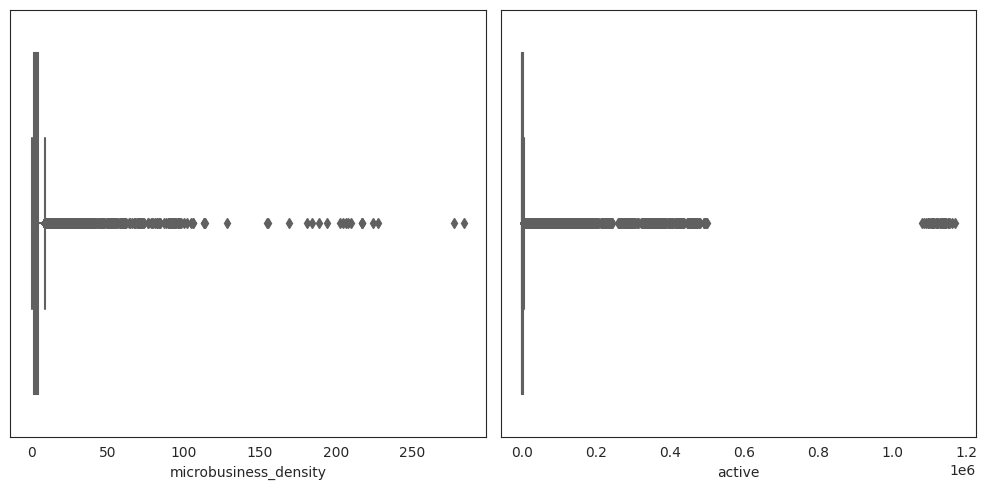

In [11]:
fig = plt.figure(figsize=(10,5))
x = 1
for feature in ['microbusiness_density', 'active']:
    ax = fig.add_subplot(1,2,x)
    sn.boxplot(x=train[feature], color="#FF4040")
    x+=1
plt.tight_layout()
plt.show()

**Counts of State occurances **


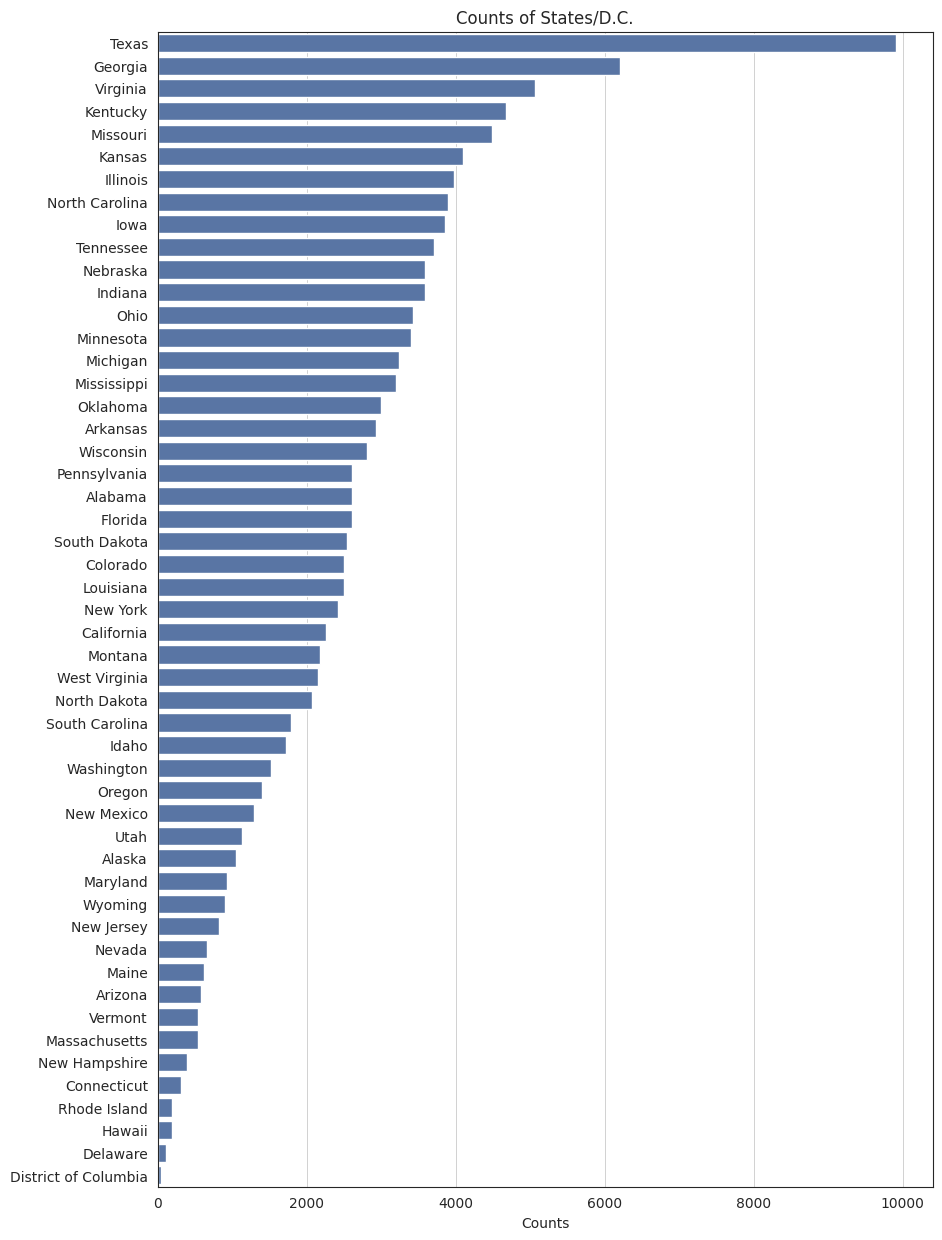

In [12]:
fig = plt.figure(figsize=(10,15))
sn.countplot(data=train, y="state", order=train['state'].value_counts().index, color="#4C72B0")
plt.ylabel("")
plt.xlabel("Counts")
plt.title("Counts of States/D.C.")
plt.grid(True, color = "grey", linewidth = "0.5", alpha=0.5, axis="x")
plt.show()

Scatterplots of Microbusiness_Density



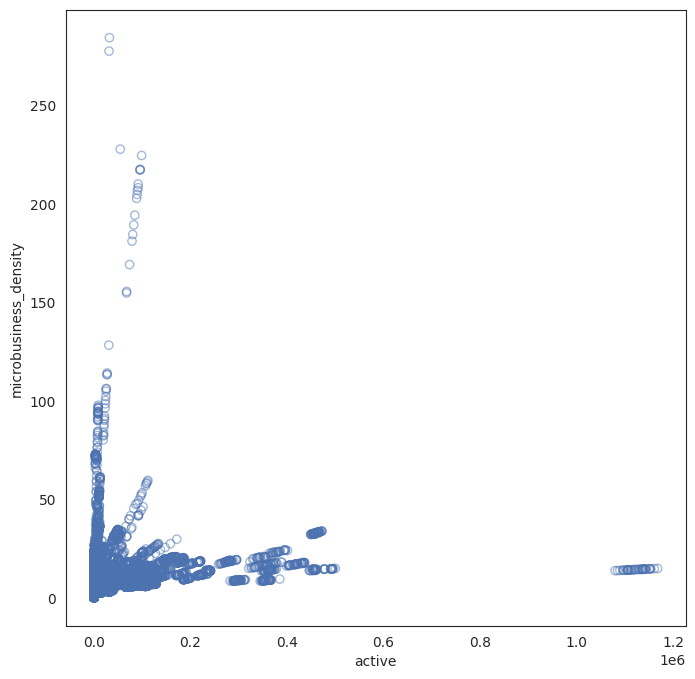

In [13]:
fig = plt.figure(figsize=(8,8))
plt.scatter(y=train["microbusiness_density"], x=train["active"], color="#4C72B0", alpha=.5, facecolors="none")
plt.xlabel("active")
plt.ylabel("microbusiness_density")
plt.show()

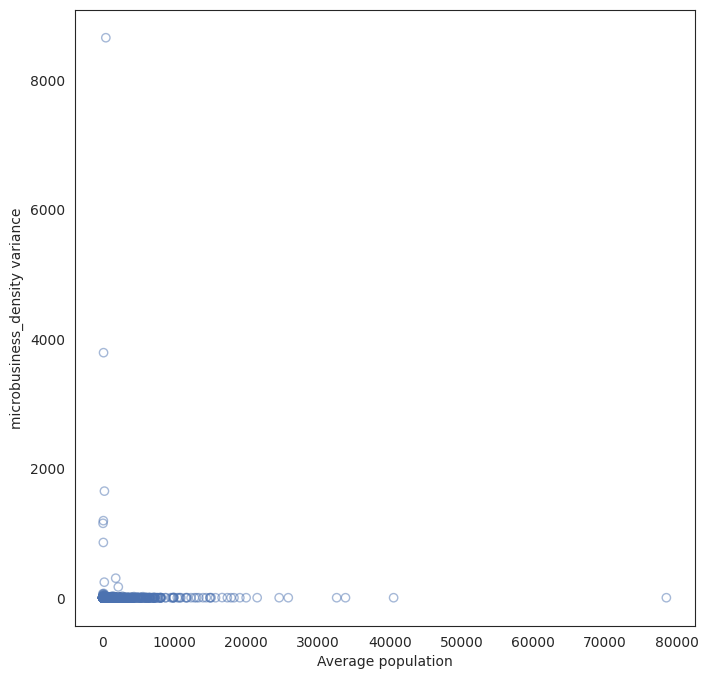

In [14]:
avg_pop = pd.concat([train['cfips'], train['active']/train['microbusiness_density']], axis=1).groupby(by='cfips').mean().reset_index()
avg_pop.columns = ['cfips', 'avg_population']

var_business = pd.concat([train['cfips'], train['microbusiness_density']], axis=1).groupby(by='cfips').var().reset_index()
var_business.columns = ['cfips', 'var_business']

fig = plt.figure(figsize=(8,8))
plt.scatter(y=var_business['var_business'], x=avg_pop['avg_population'], color="#4C72B0", alpha=.5, facecolors="none")
plt.xlabel("Average population")
plt.ylabel("microbusiness_density variance")
plt.show()

**Boxplots of Microbusiness_Density By State**



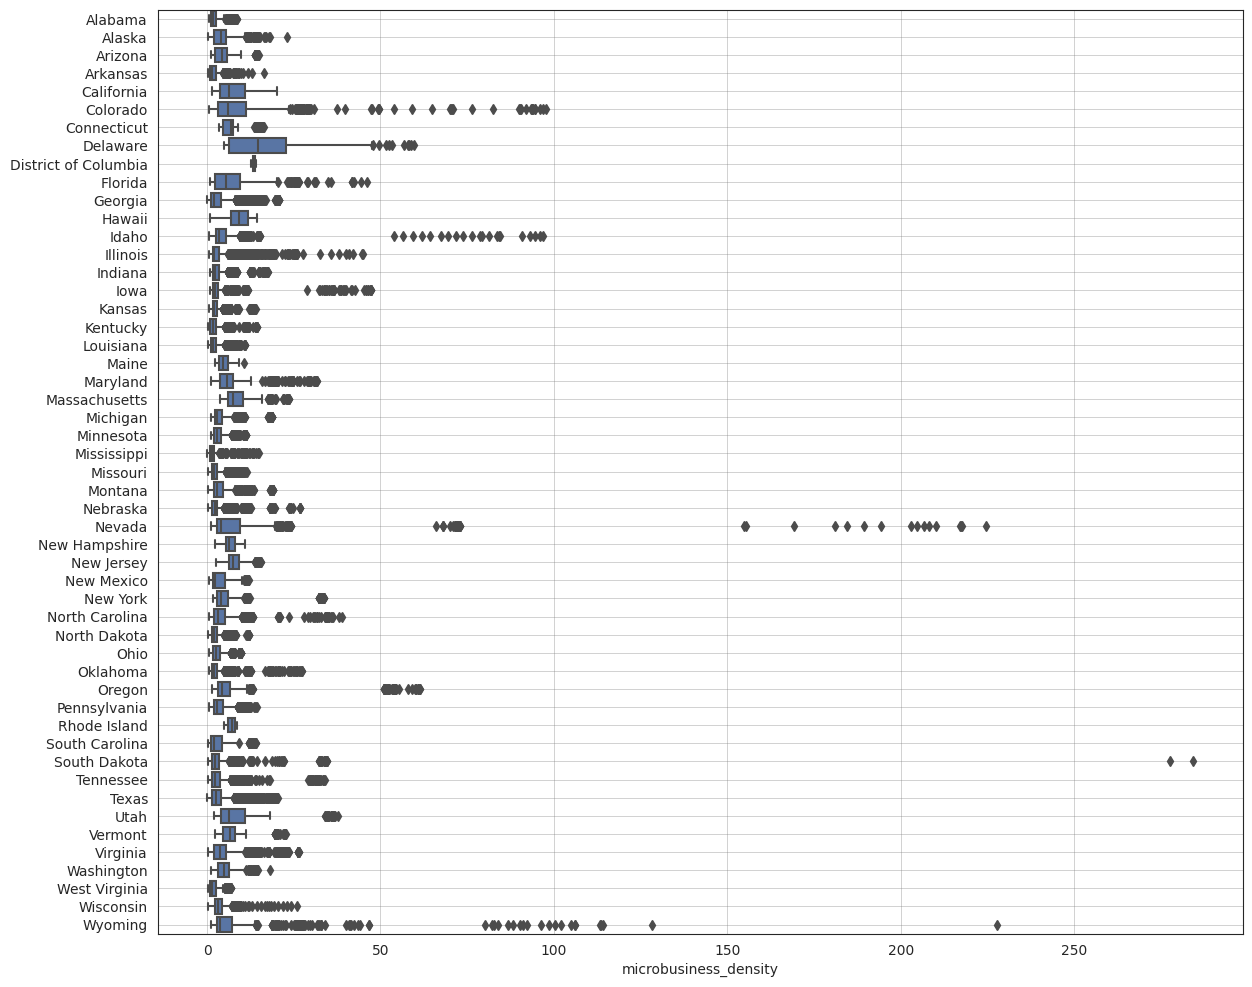

In [15]:
fig = plt.figure(figsize=(14,12))
sn.boxplot(data=train, y="state", x="microbusiness_density",color="#4C72B0")
plt.grid(True, color = "grey", linewidth = "0.5", alpha=0.5, axis="both")
plt.ylabel("")
plt.show()

Plot of Microbusiness_Density Over time
**bold text**


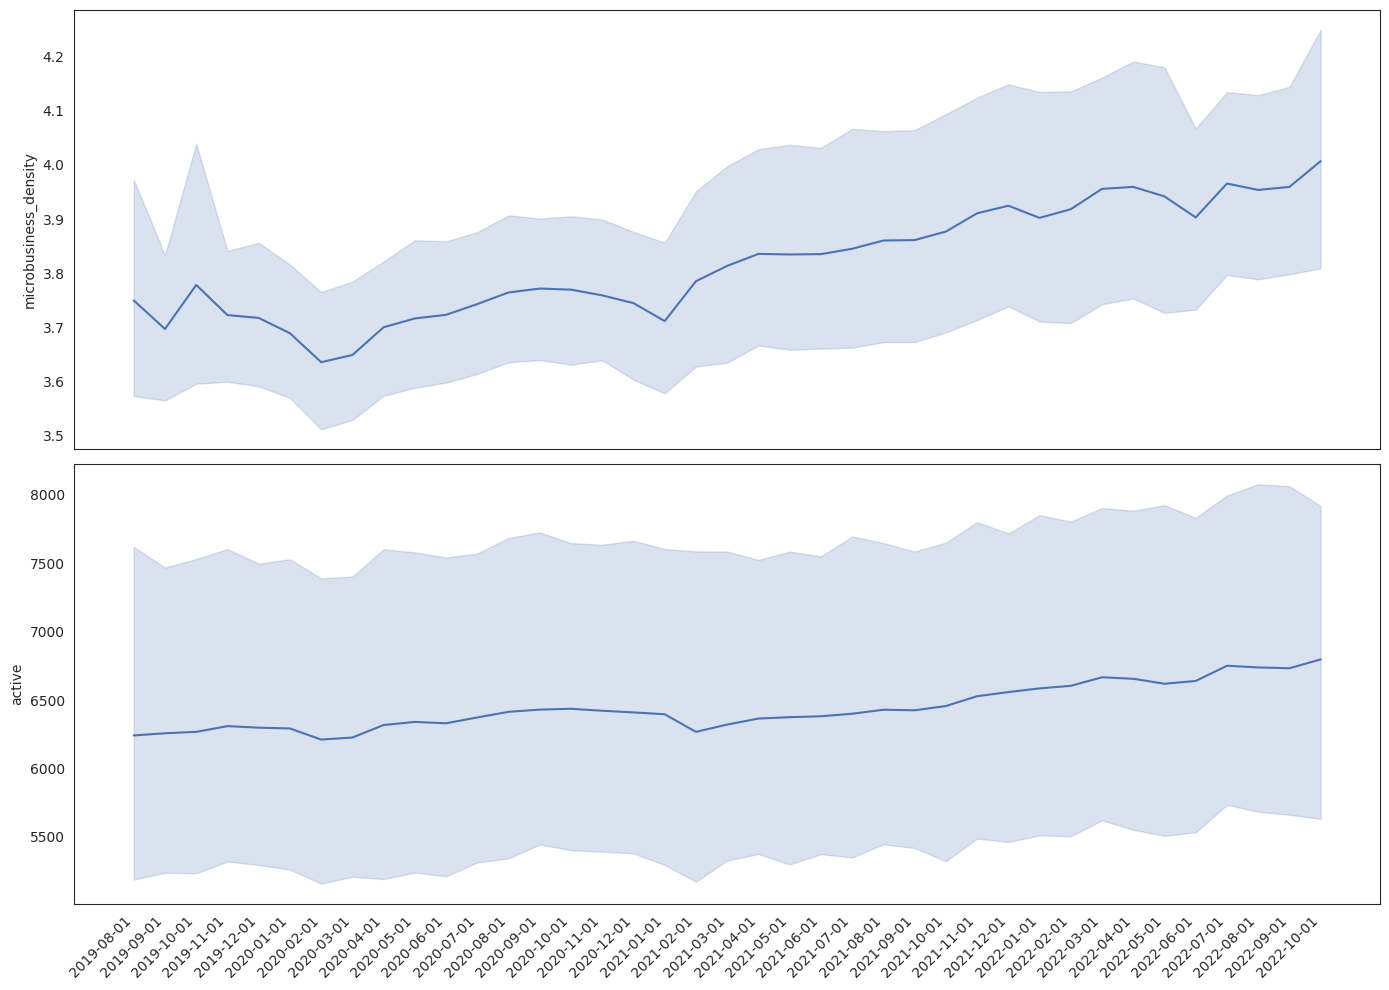

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(14,10), sharex=True)
sn.lineplot(x=train["first_day_of_month"], y=train["microbusiness_density"], color="#4C72B0",ax=ax1)
sn.lineplot(x=train["first_day_of_month"], y=train["active"], color="#4C72B0", ax=ax2)
plt.xticks(rotation=45, ha='right')
plt.xlabel("")
plt.tight_layout()
plt.show()

**Plots of Microbusiness_Density Over Time Seperated By State**

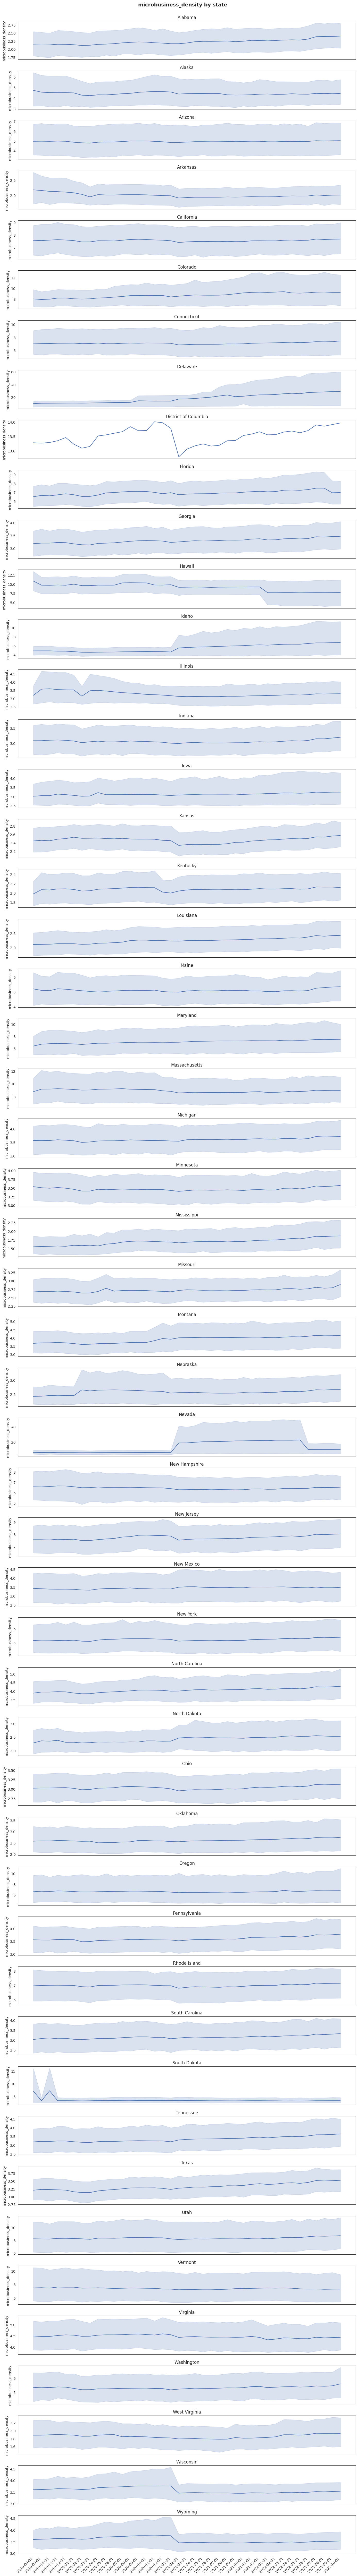

In [18]:
fig = plt.figure(figsize=(14,100))
x = 1
for unique_state in train["state"].unique()[:-1]:
    ax = fig.add_subplot(51,1,x)
    sn.lineplot(x=train.loc[train["state"] == unique_state, "first_day_of_month"], y=train.loc[train["state"] == unique_state,"microbusiness_density"], color="#4C72B0")
    plt.title(unique_state)
    plt.xlabel("")
    plt.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)
    x+=1
ax = fig.add_subplot(51,1,x)
sn.lineplot(x=train.loc[train["state"] == unique_state, "first_day_of_month"], y=train.loc[train["state"] == unique_state,"microbusiness_density"], color="#4C72B0")
plt.title(train["state"].unique()[-1])
plt.xticks(rotation=45, ha='right')
plt.xlabel("")
ttl = plt.suptitle("microbusiness_density by state", fontsize=14, fontweight="bold")
ttl.set_position([.51, 1.00])
plt.tight_layout()
plt.show()

**Correlation Between Microbusiness_Density And Date Seperated By State**

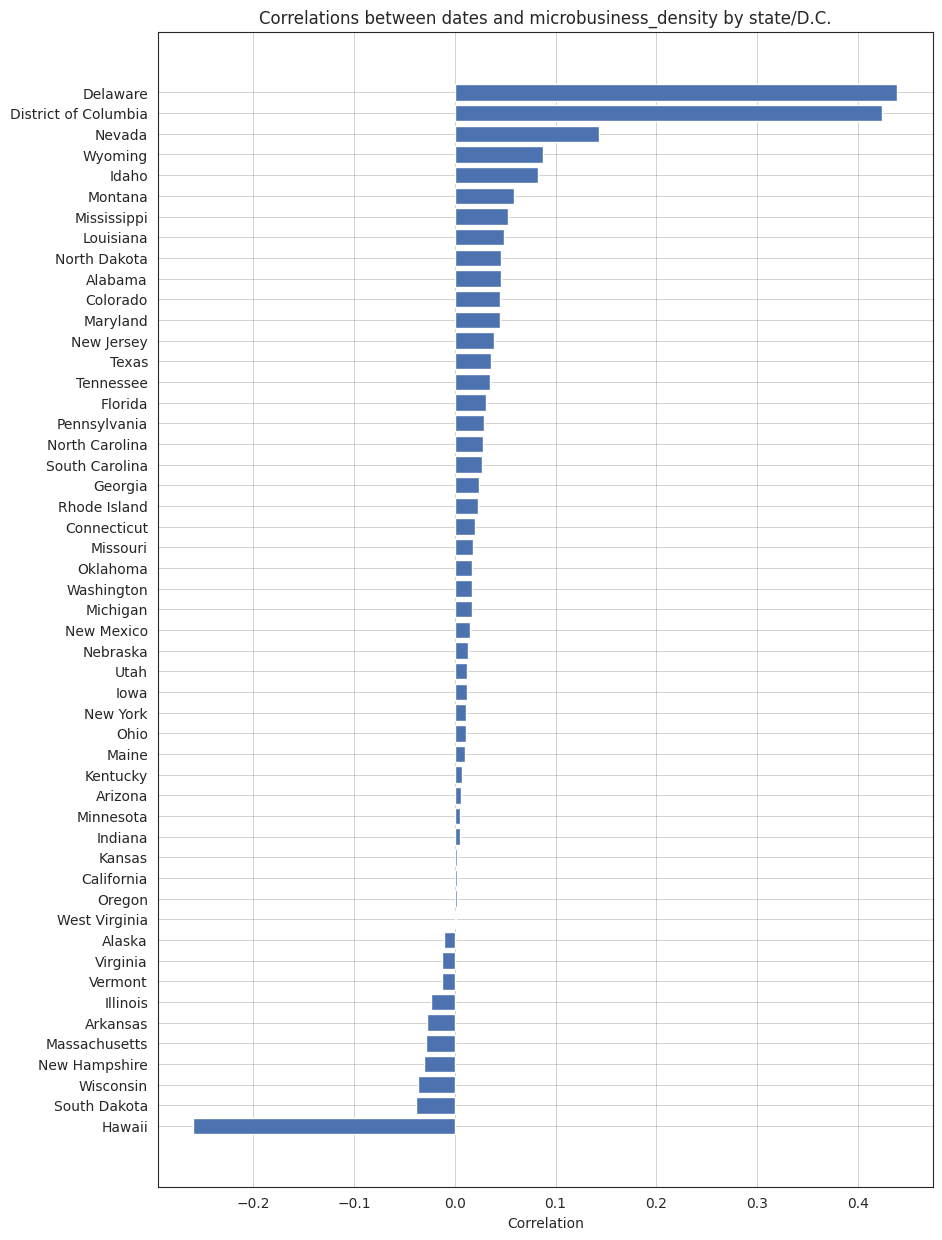

In [19]:
days_conversion = list()
for date in pd.to_datetime(train["first_day_of_month"]):
    days_conversion.append((date - pd.to_datetime(date.today())).days)

temp = pd.concat([pd.Series(days_conversion),
                  train["state"],
                  train["microbusiness_density"]],
                 axis=1)
temp.columns = ["days_since", "state", "microbusiness_density"]

corr_by_state = list()
for state in temp["state"].unique():
    corr_by_state.append(temp.loc[temp["state"]==state, ["days_since", "microbusiness_density"]].corr().values[0][1])
corr_by_state = pd.Series(corr_by_state, index=temp["state"].unique())

fig = plt.figure(figsize=(10,15))
plt.barh(width=corr_by_state.sort_values().values,
          y=corr_by_state.sort_values().index,
          color="#4C72B0")
plt.grid(True, color = "grey", linewidth = "0.5", alpha=0.5)
plt.title("Correlations between dates and microbusiness_density by state/D.C.")
plt.xlabel("Correlation")
plt.show()

**Distribution Of Correlations Between Microbusiness_Density And Date Seperated by State**

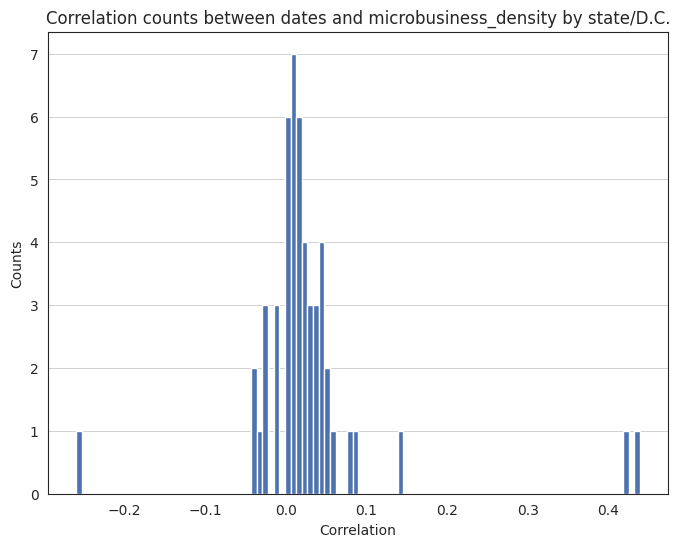

In [20]:
fig = plt.figure(figsize=(8,6))
plt.hist(corr_by_state.sort_values(), color="#4C72B0",bins=100)
plt.xlabel("Correlation")
plt.ylabel("Counts")
plt.title("Correlation counts between dates and microbusiness_density by state/D.C.")
plt.grid(True, color = "grey", linewidth = "0.5", alpha=0.5, axis="y")
plt.show()

**Distribution of Correlations Between Microbusiness_Density And Date Seperated By County**

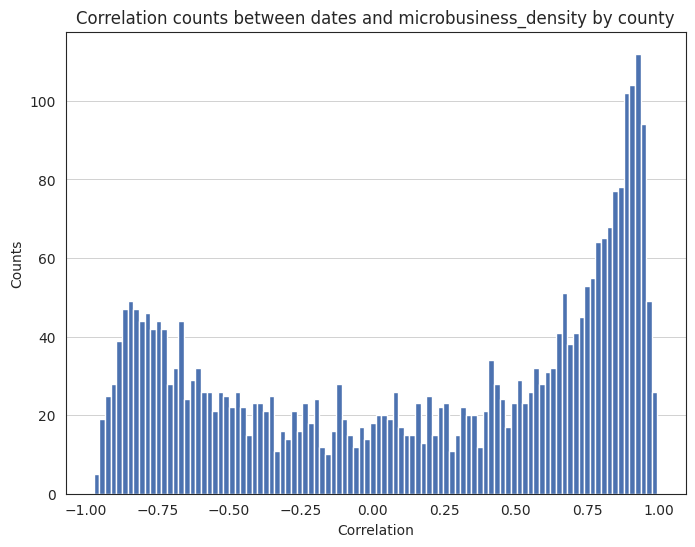

In [21]:
temp = pd.concat([pd.Series(days_conversion),
                  train["county"] + ", " + train["state"],
                  train["state"],
                  train["microbusiness_density"]],
                 axis=1)
temp.columns = ["days_since", "county_state", "state", "microbusiness_density"]

corr_by_county = list()
for county in temp["county_state"].unique():
    corr_by_county.append(temp.loc[temp["county_state"]==county, ["days_since", "microbusiness_density"]].corr().values[0][1])
corr_by_county = pd.Series(corr_by_county, index=temp["county_state"].unique())

fig = plt.figure(figsize=(8,6))
plt.hist(corr_by_county.sort_values(), color="#4C72B0",bins=100)
plt.xlabel("Correlation")
plt.ylabel("Counts")
plt.title("Correlation counts between dates and microbusiness_density by county")
plt.grid(True, color = "grey", linewidth = "0.5", alpha=0.5, axis="y")
plt.show()

**10 largest positive correlations between microbusiness_density and dates seperated by county**

In [22]:
N_COUNTIES = 10


**Lineplots**

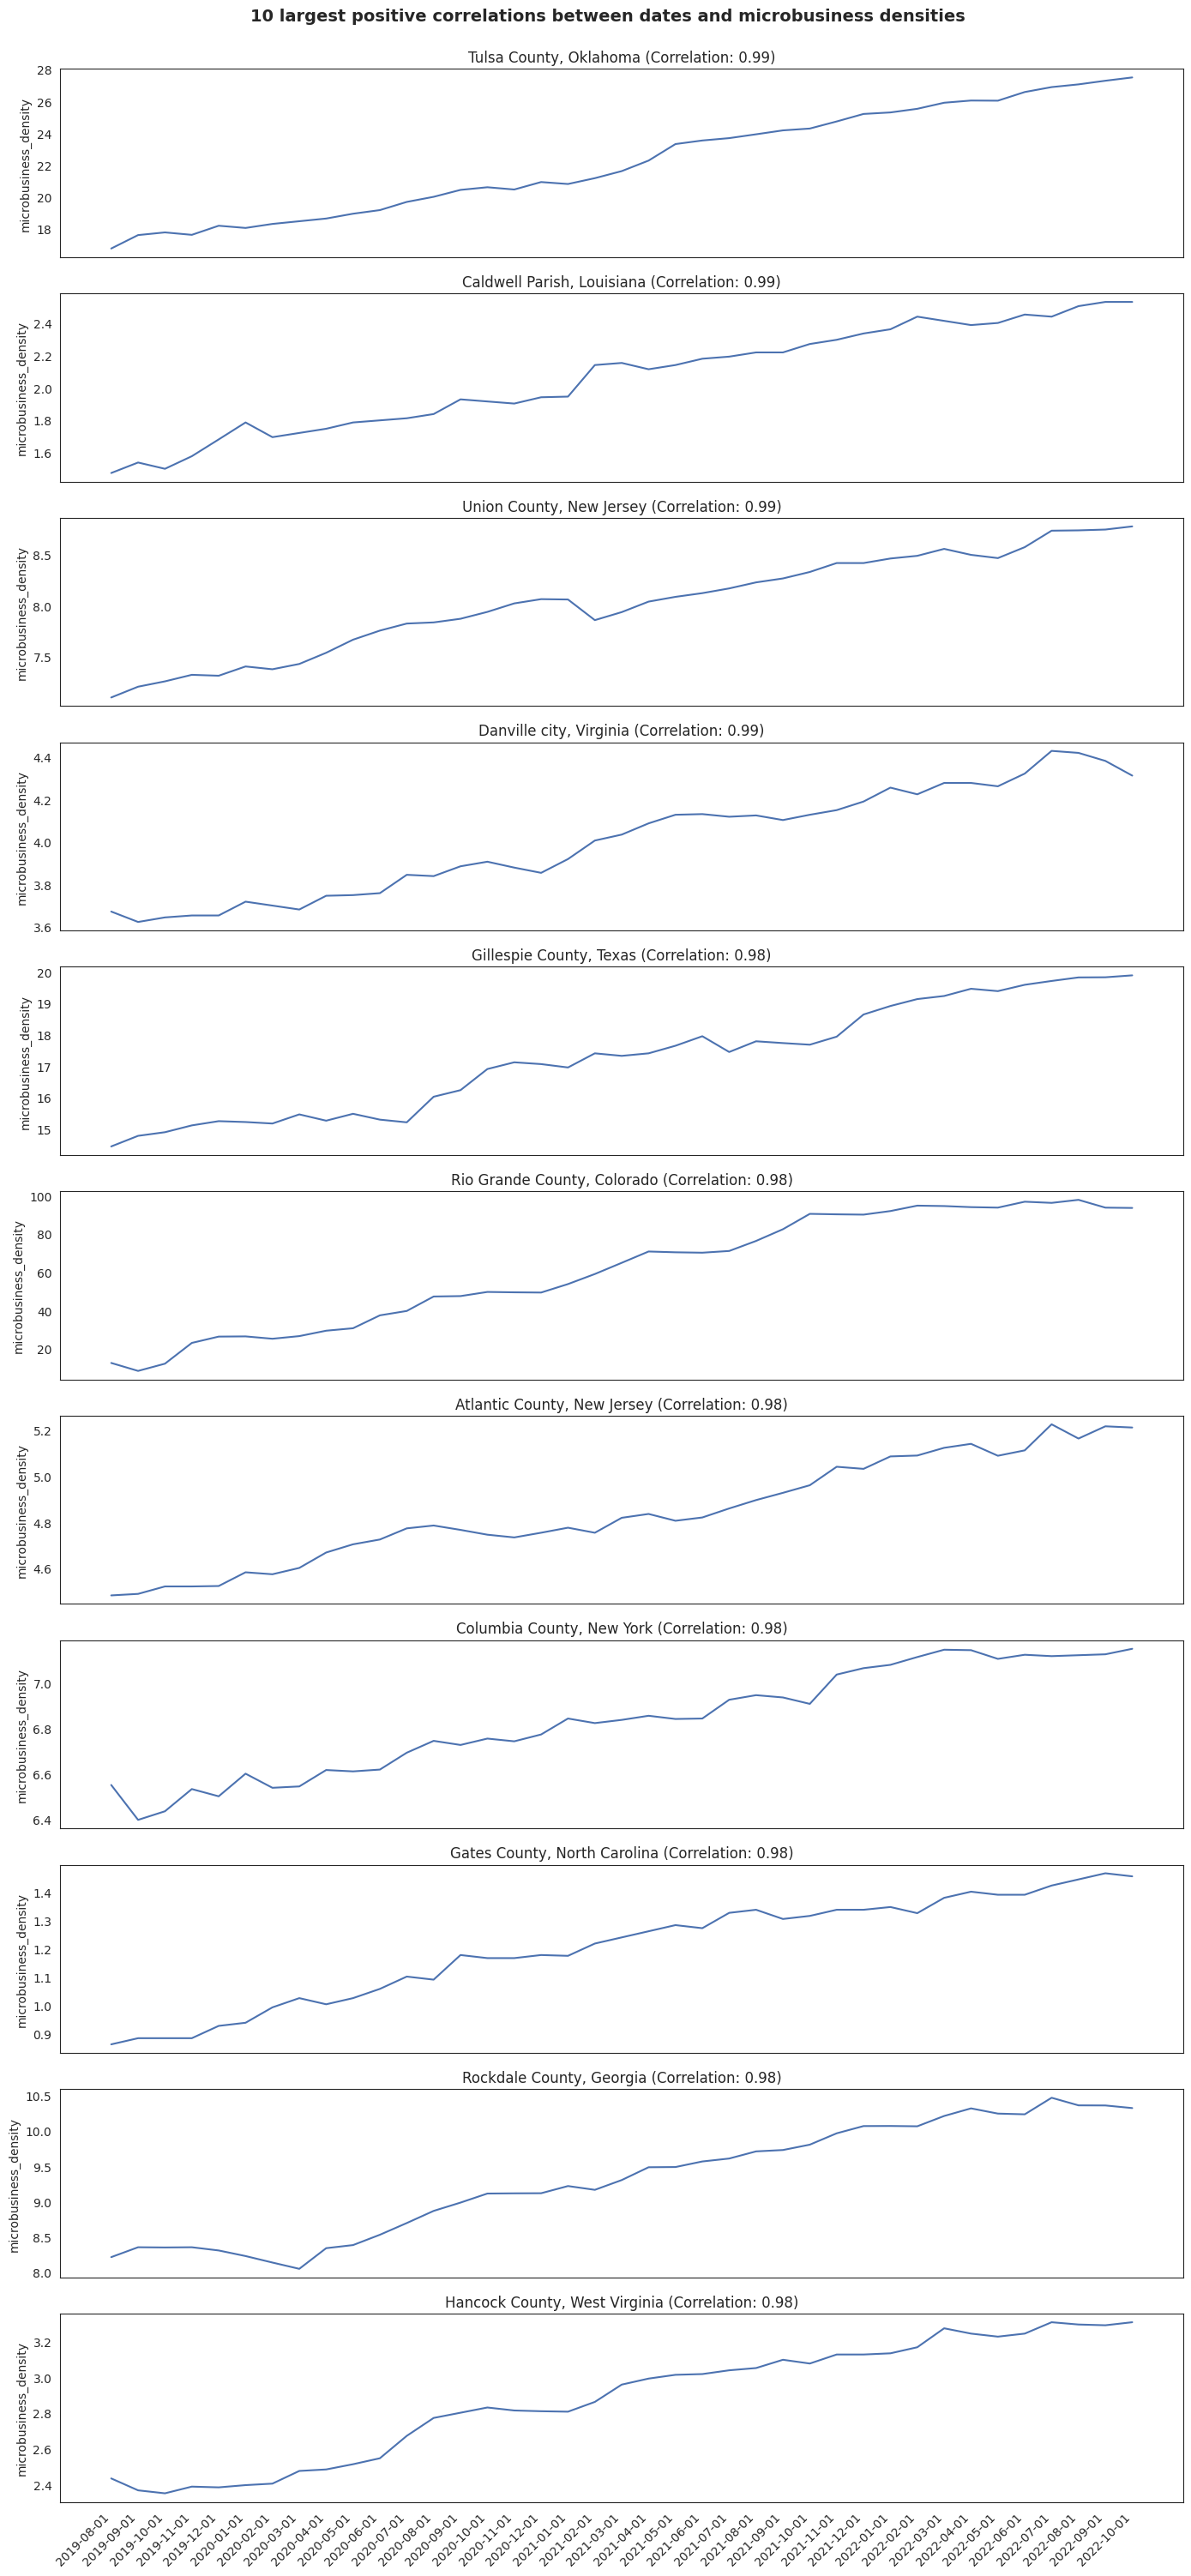

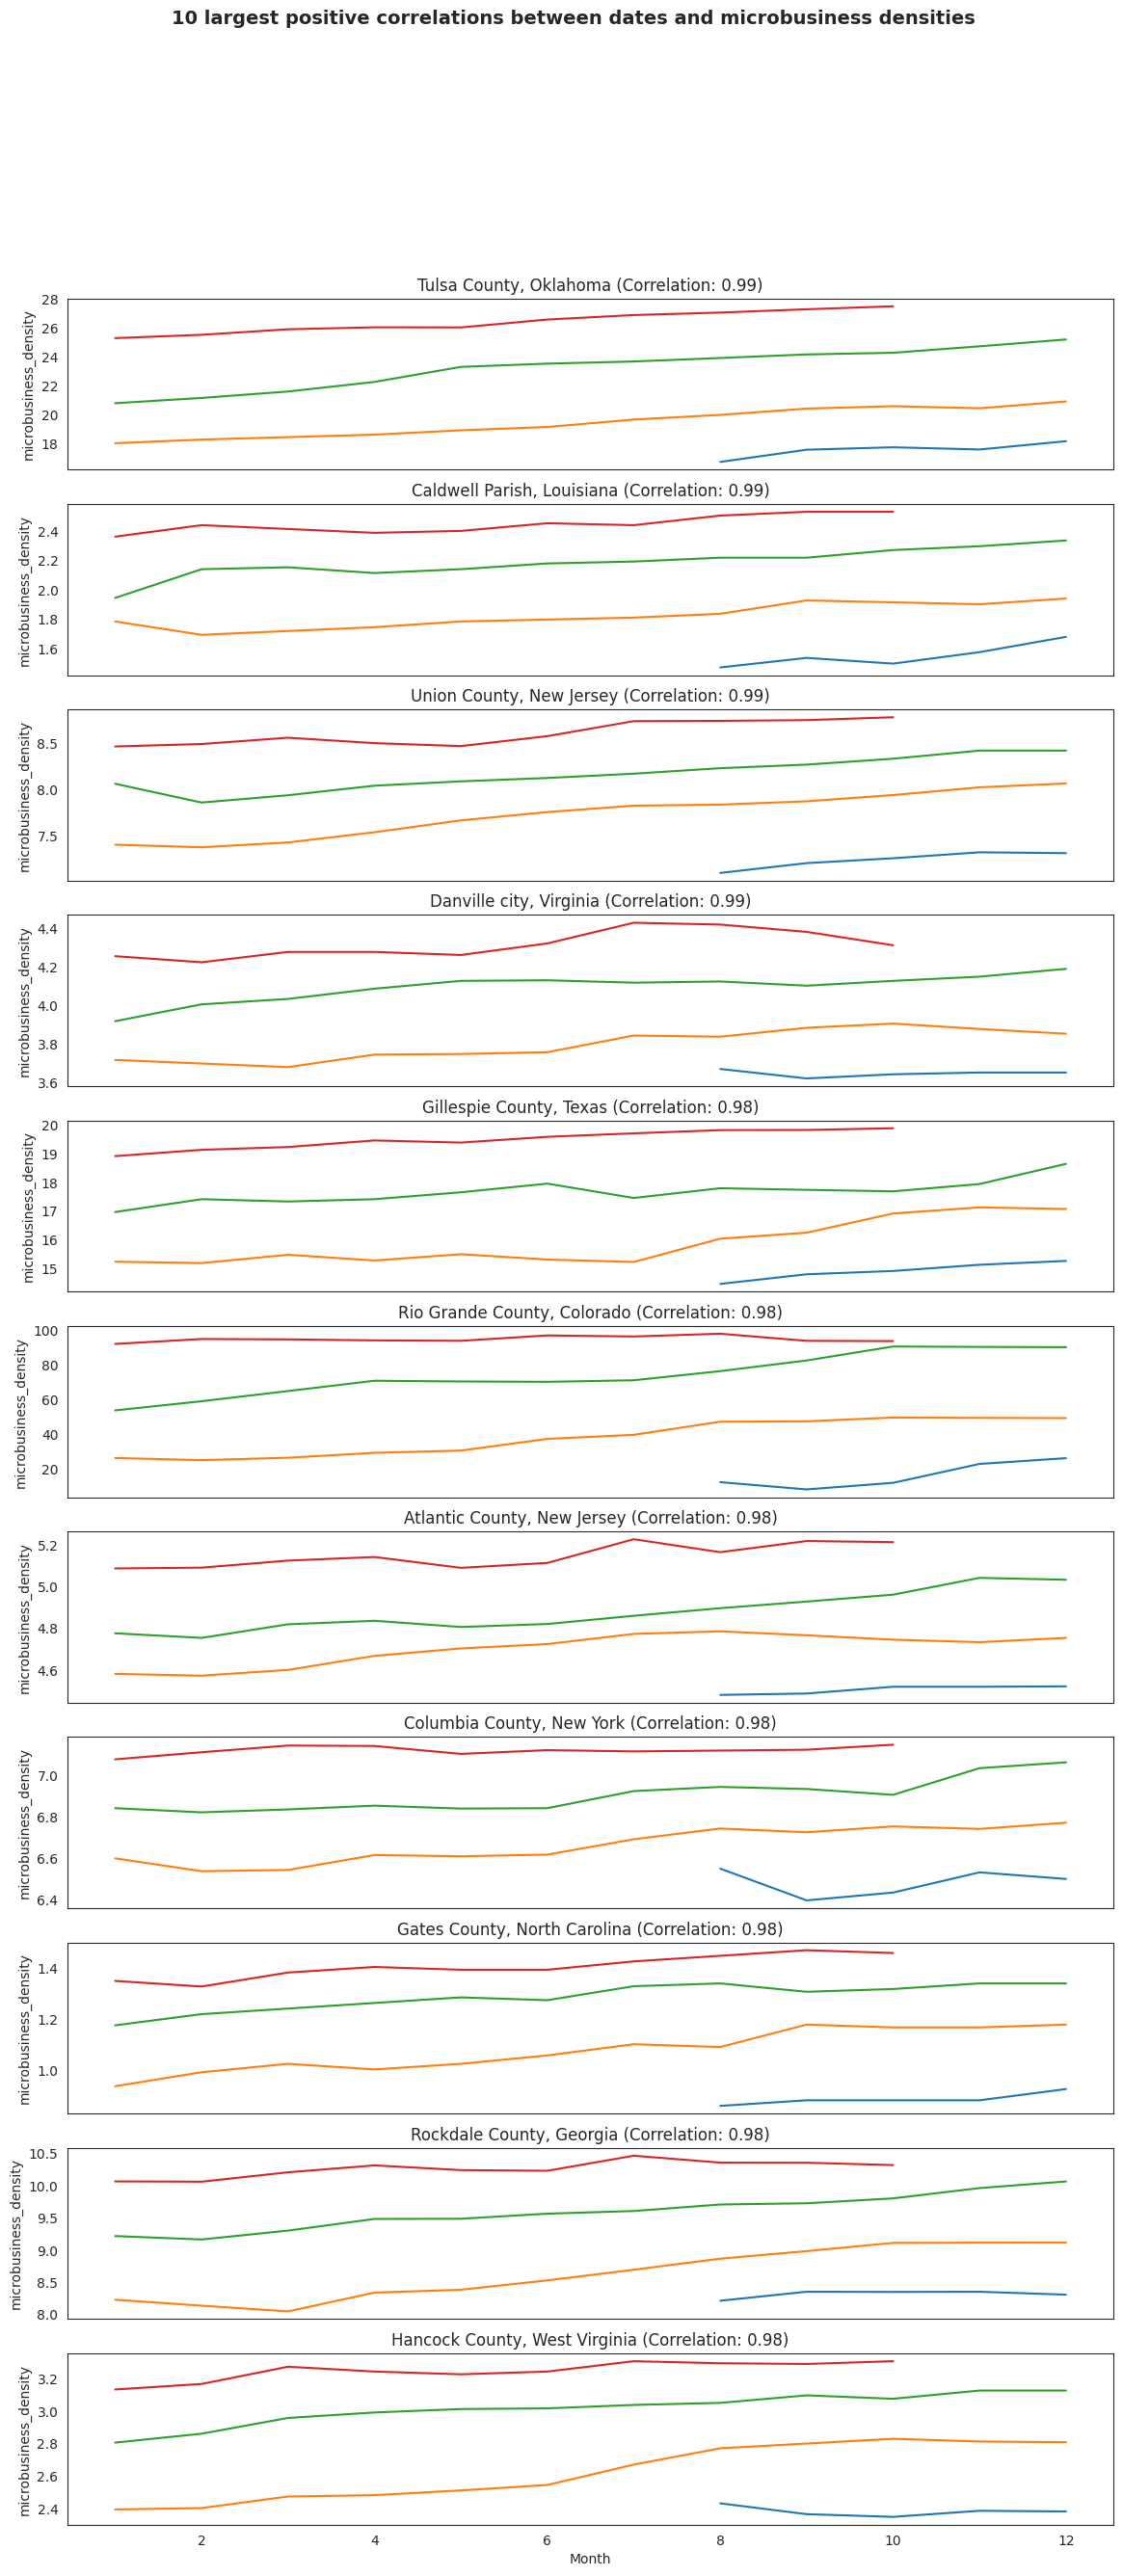

In [24]:
fig = plt.figure(figsize=(14,N_COUNTIES*3))
x = 1
for idx, county in enumerate(corr_by_county.sort_values(ascending=False).index[:N_COUNTIES]):
    ax = fig.add_subplot(N_COUNTIES+1,1,x)
    sn.lineplot(x=train.loc[temp["county_state"]==county, 'first_day_of_month'], y=train.loc[temp["county_state"]==county, "microbusiness_density"], color="#4C72B0")
    plt.title(county + f" (Correlation: {np.round(corr_by_county.sort_values(ascending=False).values[:N_COUNTIES][idx],2)})")
    plt.xlabel("")
    plt.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)
    x+=1
ax = fig.add_subplot(N_COUNTIES+1,1,x)
sn.lineplot(x=train.loc[temp["county_state"]==corr_by_county.sort_values(ascending=False).index[N_COUNTIES], 'first_day_of_month'], y=train.loc[temp["county_state"]==corr_by_county.sort_values(ascending=False).index[N_COUNTIES], "microbusiness_density"], color="#4C72B0")
plt.title(corr_by_county.sort_values(ascending=False).index[:N_COUNTIES+1][-1] + f" (Correlation: {np.round(corr_by_county.sort_values(ascending=False).values[:N_COUNTIES+1][-1],2)})")
plt.xticks(rotation=45, ha='right')
plt.xlabel("")
ttl = plt.suptitle(f"{N_COUNTIES} largest positive correlations between dates and microbusiness densities", fontsize=14, fontweight="bold")
ttl.set_position([.51, 1.00])
plt.tight_layout()
plt.show()
fig = plt.figure(figsize=(14,N_COUNTIES*3))
x = 1
for idx, county in enumerate(corr_by_county.sort_values(ascending=False).index[:N_COUNTIES]):
    ax = fig.add_subplot(N_COUNTIES+1,1,x)
    for year in pd.to_datetime(train.loc[temp["county_state"]==county, 'first_day_of_month']).dt.year.unique():
        sn.lineplot(x=pd.to_datetime(train.loc[temp["county_state"]==county, 'first_day_of_month']).dt.month,
                    y=train.loc[(temp["county_state"]==county)&(pd.to_datetime(train.loc[temp["county_state"]==county,'first_day_of_month']).dt.year == year),"microbusiness_density"])
    plt.title(county + f" (Correlation: {np.round(corr_by_county.sort_values(ascending=False).values[:N_COUNTIES][idx],2)})")
    plt.xlabel("")
    plt.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
  labelbottom=False)
    x+=1
ax = fig.add_subplot(N_COUNTIES+1,1,x)
for year in pd.to_datetime(train.loc[temp["county_state"]==corr_by_county.sort_values(ascending=False).index[N_COUNTIES], 'first_day_of_month']).dt.year.unique():
    sn.lineplot(x=pd.to_datetime(train.loc[temp["county_state"]==corr_by_county.sort_values(ascending=False).index[N_COUNTIES], 'first_day_of_month']).dt.month,
                y=train.loc[(temp["county_state"]==corr_by_county.sort_values(ascending=False).index[N_COUNTIES])&(pd.to_datetime(train.loc[temp["county_state"]==corr_by_county.sort_values(ascending=False).index[N_COUNTIES],
                                                                                     'first_day_of_month']).dt.year == year),
                            "microbusiness_density"])
# sn.lineplot(x=train.loc[temp["county_state"]==corr_by_county.sort_values(ascending=False).index[N_COUNTIES], 'first_day_of_month'], y=train.loc[temp["county_state"]==corr_by_county.sort_values(ascending=False).index[N_COUNTIES], "microbusiness_density"], color="#4C72B0")
plt.title(corr_by_county.sort_values(ascending=False).index[:N_COUNTIES+1][-1] + f" (Correlation: {np.round(corr_by_county.sort_values(ascending=False).values[:N_COUNTIES+1][-1],2)})")
plt.xlabel("Month")
ttl = plt.suptitle(f"{N_COUNTIES} largest positive correlations between dates and microbusiness densities\n", fontsize=14, fontweight="bold")
